# Toxic Comment Detector
Sentiment analysis is an important task among machine learning that aims to understand the attitude or sentiment of a person about a theme. In this workshop we will build a Sentiment Analysis for toxic comments detection using a database provided by Jigsaw https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge using Keras.

## Download the database
Let's download the database and explore some of the data

In [1]:
!wget http://tiny.cc/toxic_datostada

--2020-03-12 05:39:06--  http://tiny.cc/toxic_datostada
Resolving tiny.cc (tiny.cc)... 192.241.240.89
Connecting to tiny.cc (tiny.cc)|192.241.240.89|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tiny.cc/toxic_datostada [following]
--2020-03-12 05:39:06--  https://tiny.cc/toxic_datostada
Connecting to tiny.cc (tiny.cc)|192.241.240.89|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.google.com/uc?id=1bT3dZ00AX70X6Qo7SqaVT6FdKVCVOc9T&export=download [following]
--2020-03-12 05:39:07--  https://drive.google.com/uc?id=1bT3dZ00AX70X6Qo7SqaVT6FdKVCVOc9T&export=download
Resolving drive.google.com (drive.google.com)... 172.217.204.138, 172.217.204.101, 172.217.204.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcu

In [2]:
!ls

sample_data  toxic_datostada


In [0]:
mv toxic_datostada train.csv

In [4]:
import pandas as pd, numpy as np
train = pd.read_csv('./train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Data preprocessing
Check for null values and replace it with anything.

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Install sutil library and perform the preprocessing.

In [6]:
!pip install soldai-utils

In [0]:
from sutil.text.StringJanitor import StringJanitor
janitor = StringJanitor(space_char=' ')
train['clean'] = train.comment_text.apply(janitor.clean)

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww he matches this background colour im seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i cant make any real suggestions on impr...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [9]:
toxic = train[train.toxic == 1]
toxic.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,cocksucker before you piss around on my work
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,hey what is it talk what is it an exclusive...
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,bye dont look come or think of comming back to...
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,you are gay or antisemmitian archangel white t...
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,fuck your filthy mother in the ass dry


## Balance the classes

In [10]:
toxic = train[train.toxic == 1]
non_toxic = train[train.toxic == 0].sample(n = len(toxic))
print(len(toxic), len(non_toxic))
balanced = pd.concat([toxic, non_toxic]).sample(n= 2*len(toxic))
print(len(balanced))
balanced.reset_index()
balanced.head()

15294 15294
30588


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
85240,e405881c43008e32,GUYZERO BITE ME\nGO AHEAD AND BLOCK THE IP I D...,1,0,1,0,1,0,guyzero bite me go ahead and block the ip i do...
81997,db5be9a513d9d6e6,To go to subpage - misunderstandings in simple...,0,0,0,0,0,0,to go to subpage misunderstandings in simple ...
37573,645c07f7662e3335,Wikipedia:Suspected sock puppets/VacuousPoet (...,0,0,0,0,0,0,wikipediasuspected sock puppetsvacuouspoet 4th...
97136,07acf2c033452d0f,kids incorporated \n\nSHUT THE HELL UP.,1,0,1,0,0,0,kids incorporated shut the hell up
84357,e197dc34d6b049a1,because of it being from Libya's government,0,0,0,0,0,0,because of it being from libyas government


## Create the features from text
Let's create the features from the clean text

In [11]:
import sys, os, re, csv, codecs, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split

In [0]:
list_classes = ["toxic"]
y = balanced[list_classes].values
list_sentences_train = balanced["clean"]
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

## Create the train and test sets

In [0]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_t, y, test_size = 0.2)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(24470, 200) (24470, 1) (6118, 200) (6118, 1)


## Create the model

In [15]:
def createModel():
    inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
model = createModel()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (No

In [16]:
batch_size = 64
epochs = 2
model.fit(X_train,Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 22023 samples, validate on 2447 samples
Epoch 1/2
22023/22023 [==============================] - 120s 5ms/sample - loss: 0.3394 - acc: 0.8444 - val_loss: 0.2255 - val_acc: 0.9068
Epoch 2/2
22023/22023 [==============================] - 118s 5ms/sample - loss: 0.1557 - acc: 0.9399 - val_loss: 0.2383 - val_acc: 0.9076


## Plot the loss

Text(0.5, 1.0, 'Training and validation loss')

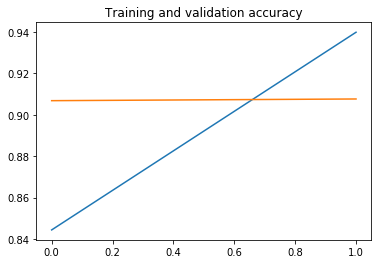

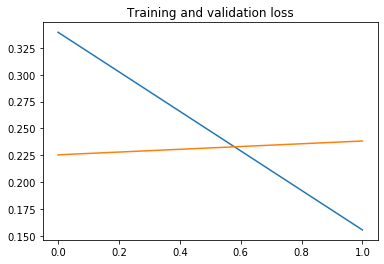

In [17]:
history = model.history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Get number of epochs\n",
epochs = range(len(acc))

# Plot training and validation accuracy per epoch\n",
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch\n",
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Evaluate the model

In [18]:
model.evaluate(X_test, Y_test, verbose=1)

6118/6118 [==============================] - 8s 1ms/sample - loss: 0.2322 - acc: 0.9109


[0.2321860480002618, 0.9109186]

In [19]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
binarized = [0 if p < 0.5 else 1 for p in predictions]
print(classification_report(Y_test, binarized))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3039
           1       0.91      0.91      0.91      3079

    accuracy                           0.91      6118
   macro avg       0.91      0.91      0.91      6118
weighted avg       0.91      0.91      0.91      6118



## Save your model

In [20]:
!pip install h5py

In [21]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Create the API

Let's create a simple API to run our model and make it acessible using the web with flask

## Create the dependencies

In [22]:
!pip install flask-ngrok

In [0]:
from flask_ngrok import run_with_ngrok
from flask import Flask

## Load the model

In [24]:
from keras.models import load_model 
from tensorflow import keras
import tensorflow as tf

session = keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)
# Reproduce the model
learn = createModel()
# load model
learn.load_weights('model.h5')
# summarize model.
learn.summary()
# Make the predict function
learn._make_predict_function()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

## Define the web API

Run the web server defined below, once the server is running you will have an http://xxxxxxxxx.ngrok.io url to access your server from internet. To test your API do the following:

* Access to https://reqbin.com/curl:

* Run the following curl command to test your server replacing the url for the one generated in the notebook:

In [0]:
!curl --header "Content-Type: application/json" \
  --request POST \
  --data '{"comportia_question_tokens": ["They are awful I hate them"]}' \
  http://8adcee5c.ngrok.io/toxic

In [25]:
import random
from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import jsonify
from flask import request
from sutil.text.StringJanitor import StringJanitor
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run


def preProcessText(text, tokenizer):
    janitor = StringJanitor(space_char=' ')
    cleaned = janitor.clean(text)
    maxlen = 200
    tokenized_text = tokenizer.texts_to_sequences([text])
    X_t = pad_sequences(tokenized_text, maxlen=maxlen)
    return X_t
    
def isToxic(text):
    featured = preProcessText(text, tokenizer)
    global session
    try:
        with session.as_default():
            with session.graph.as_default():
                predictions = learn.predict(featured)
                print(predictions)
                if predictions[0][0] > 0.5:
                    return True
    except Exception as ex:
        print("An error was encontered during the prediction")
        print(ex)
    return False

@app.route("/")
def home():
    body = "<h1>Use this Toxic API!</h1>"
    body += "<p> send the toxic comment using POST to /toxic </p>"
    return body

@app.route("/check")
def check():
    body = "<h1>Running Flask on Google Colab!</h1>"
    body += "<p> The model is ready </p>"
    return body

@app.route("/toxic", methods=['POST'])
def toxic():
    print(request.json)
    comment = request.json["comportia_question_tokens"][0]
    #comment = request.json["comment"]
    toxic = {'text': comment, 'toxic': isToxic(comment)}
    print(toxic)
    return jsonify(toxic)

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://8adcee5c.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [12/Mar/2020 06:20:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2020 06:20:01] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [12/Mar/2020 06:24:41] "POST /toxic HTTP/1.1" 200 -


{'comportia_question_tokens': ['They are awful I hate them']}
[[0.9736319]]
{'text': 'They are awful I hate them', 'toxic': True}


127.0.0.1 - - [12/Mar/2020 06:25:08] "POST /toxic HTTP/1.1" 200 -


{'comportia_question_tokens': ['They are awesome I love them']}
[[0.15842494]]
{'text': 'They are awesome I love them', 'toxic': False}


127.0.0.1 - - [12/Mar/2020 06:36:07] "POST /toxic HTTP/1.1" 200 -


{'comportia_question_tokens': ['They are awful I hate them']}
[[0.9736319]]
{'text': 'They are awful I hate them', 'toxic': True}
